In [1]:
# 设置工作路径
import os
os.chdir("C:\\Users\\15068\\Python\\在线网络计算器\\HCC")

# 获取并打印当前工作路径
current_path = os.getcwd()
print("当前工作路径:", current_path)

当前工作路径: C:\Users\15068\Python\在线网络计算器\HCC


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
df = pd.read_csv('HCC.csv')
# 划分特征和目标变量
X = df.drop(['group'], axis=1)
y = df['group']
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,                                                     
                                                    random_state=42, stratify=df['group'])
df.head()

,group,original_shape_Elongation_A,log.sigma.1.0.mm.3D_glcm_Correlation_A,lbp.3D.k_gldm_DependenceEntropy_A,original_glcm_Autocorrelation,original_gldm_LargeDependenceHighGrayLevelEmphasis,log.sigma.1.0.mm.3D_firstorder_Median,log.sigma.1.0.mm.3D_glrlm_ShortRunHighGrayLevelEmphasis,wavelet.HHL_ngtdm_Complexity,exponential_glcm_InverseVariance,Alcohol,AFP,ALT,AST
0,0,0.679792,0.560329,0.092554,-0.877548,-0.255411,0.295247,-0.509144,-1.093664,-1.015756,1,2.23,145,170
1,0,0.069201,-1.076991,-0.655127,-0.498904,-0.259421,0.245025,-0.485586,1.534893,1.088139,0,247.00,56,56
2,0,0.599145,0.643127,0.278116,-0.582540,-0.395261,0.266835,1.621967,0.988484,0.793184,0,4318.00,27,44
3,0,0.100432,-0.368800,-0.350613,-0.939188,-0.265648,0.298624,0.086305,-1.244224,-1.248686,1,37.20,52,45
4,0,1.021008,0.497653,0.646355,0.405431,-0.242340,0.257998,-1.964031,0.911806,-0.527897,0,1919.00,178,131


In [3]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# XGBoost模型参数
params_xgb = {    
    'learning_rate': 0.02,            # 学习率，控制每一步的步长，用于防止过拟合。典型值范围：0.01 - 0.1    
    'booster': 'gbtree',              # 提升方法，这里使用梯度提升树（Gradient Boosting Tree）    
    'objective': 'binary:logistic',   # 损失函数，这里使用逻辑回归，用于二分类任务    
    'max_leaves': 127,                # 每棵树的叶子节点数量，控制模型复杂度。较大值可以提高模型复杂度但可能导致过拟合    
    'verbosity': 1,                   # 控制 XGBoost 输出信息的详细程度，0表示无输出，1表示输出进度信息    
    'seed': 42,                       # 随机种子，用于重现模型的结果    
    'nthread': -1,                    # 并行运算的线程数量，-1表示使用所有可用的CPU核心    
    'colsample_bytree': 0.6,          # 每棵树随机选择的特征比例，用于增加模型的泛化能力    
    'subsample': 0.7,                 # 每次迭代时随机选择的样本比例，用于增加模型的泛化能力    
    'eval_metric': 'logloss'          # 评价指标，这里使用对数损失（logloss）
}

# 初始化XGBoost分类模型
model_xgb = xgb.XGBClassifier(**params_xgb)

# 定义参数网格，用于网格搜索
param_grid = {    
    'n_estimators': [100, 200, 300, 400, 500],  # 树的数量    
    'max_depth': [3, 4, 5, 6, 7],               # 树的深度    
    'learning_rate': [0.01, 0.02, 0.05, 0.1],   # 学习率
}

# 使用GridSearchCV进行网格搜索和k折交叉验证
grid_search = GridSearchCV(    
    estimator=model_xgb,    
    param_grid=param_grid,    
    scoring='neg_log_loss',  # 评价指标为负对数损失    
    cv=5,                    # 5折交叉验证    
    n_jobs=4,               # 并行计算    
    verbose=1                # 输出详细进度信息
)

# 训练模型
grid_search.fit(X_train, y_train)

# 输出最优参数
print("Best parameters found: ", grid_search.best_params_)
print("Best Log Loss score: ", -grid_search.best_score_)

# 使用最优参数训练模型
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 400}
Best Log Loss score:  0.3810848076917207


In [4]:
from sklearn.metrics import classification_report
# 预测测试集
y_pred = best_model.predict(X_test)
# 输出模型报告， 查看评价指标
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88        40
           1       0.25      0.12      0.17         8

    accuracy                           0.79        48
   macro avg       0.55      0.53      0.52        48
weighted avg       0.74      0.79      0.76        48



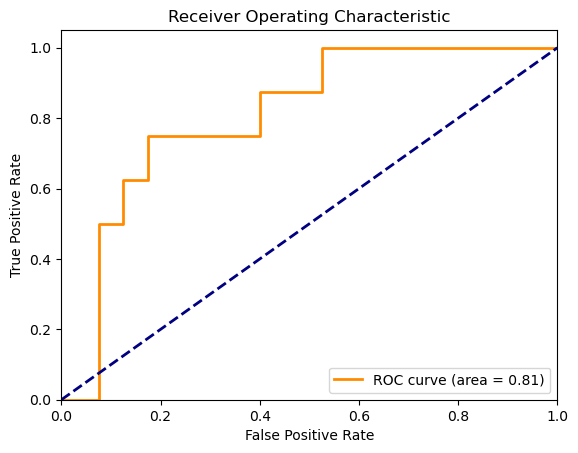

In [5]:
from sklearn.metrics import roc_curve, auc
# 预测概率
y_score = best_model.predict_proba(X_test)[:, 1]
# 计算ROC曲线
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_score)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)
# 绘制ROC曲线
plt.figure()
plt.plot(fpr_logistic, tpr_logistic, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_logistic)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [6]:
import joblib
# 保存模型
joblib.dump(best_model , 'XGBoost.pkl')

['XGBoost.pkl']

In [9]:
import streamlit as st
import joblib
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

# -----------------------------
# 1. 加载模型 & 数据
# -----------------------------
# TODO：这里改成你实际的模型文件名，如 "HCC_SVM.pkl"
MODEL_PATH = "XGBoost.pkl"
DATA_PATH = "HCC.csv"

@st.cache_resource
def load_model():
    model = joblib.load(MODEL_PATH)
    return model

@st.cache_data
def load_data():
    df = pd.read_csv(DATA_PATH)
    return df

model = load_model()
data = load_data()

# 特征名（按 HCC.csv 中除 group 外的所有列）
feature_names = [
    'original_shape_Elongation_A',
    'log.sigma.1.0.mm.3D_glcm_Correlation_A',
    'lbp.3D.k_gldm_DependenceEntropy_A',
    'original_glcm_Autocorrelation',
    'original_gldm_LargeDependenceHighGrayLevelEmphasis',
    'log.sigma.1.0.mm.3D_firstorder_Median',
    'log.sigma.1.0.mm.3D_glrlm_ShortRunHighGrayLevelEmphasis',
    'wavelet.HHL_ngtdm_Complexity',
    'exponential_glcm_InverseVariance',
    'Alcohol',
    'AFP',
    'ALT',
    'AST'
]

X_all = data[feature_names]

# 预计算每个特征的 min / max / median，方便给 number_input 用
stats = X_all.agg(['min', 'max', 'median'])

# -----------------------------
# 2. 构建 SHAP 解释器（KernelExplainer，兼容 SVM/Logistic 等）
# -----------------------------
def build_shap_explainer(model, X_background):
    """
    使用部分样本作为背景数据，构建 KernelExplainer。
    f(x) 返回阳性（group=1）的预测概率。
    """
    # 随机采样一部分样本作为背景（避免太慢）
    background = X_background.sample(
        n=min(50, len(X_background)),
        random_state=0
    )

    # 定义返回阳性概率的预测函数
    def f(x):
        return model.predict_proba(x)[:, 1]

    explainer = shap.KernelExplainer(f, background)
    return explainer

explainer = build_shap_explainer(model, X_all)

# -----------------------------
# 3. Streamlit 页面布局
# -----------------------------
st.title("HCC 疗效预测在线计算器（联合模型）")

st.markdown("""
本工具基于机器学习模型，对接受特定治疗方案的肝细胞癌（HCC）患者进行**疗效（如客观缓解 vs 非缓解）预测**。  
输入患者的临床指标及影像组学特征后，模型将给出达到 **“良好疗效（如 CR/PR）”** 的概率，并提供 SHAP 可解释图。
> ⚠️ 本计算器仅用于科研和教学目的，不能替代临床医生的专业判断。
""")

st.subheader("1. 输入变量")

st.markdown("**（1）影像组学特征（已标准化的 Z-score 值）**")

# radiomics 特征输入：使用数据中的 min/max/median，step 0.01
input_values = {}

for col in [
    'original_shape_Elongation_A',
    'log.sigma.1.0.mm.3D_glcm_Correlation_A',
    'lbp.3D.k_gldm_DependenceEntropy_A',
    'original_glcm_Autocorrelation',
    'original_gldm_LargeDependenceHighGrayLevelEmphasis',
    'log.sigma.1.0.mm.3D_firstorder_Median',
    'log.sigma.1.0.mm.3D_glrlm_ShortRunHighGrayLevelEmphasis',
    'wavelet.HHL_ngtdm_Complexity',
    'exponential_glcm_InverseVariance'
]:
    input_values[col] = st.number_input(
        label=f"{col}（标准化特征）",
        min_value=float(stats.loc['min', col]),
        max_value=float(stats.loc['max', col]),
        value=float(stats.loc['median', col]),
        step=0.01,
        format="%.4f"
    )

st.markdown("---")
st.markdown("**（2）临床特征**")

# Alcohol：0/1
alcohol_value = st.selectbox(
    "Alcohol（饮酒史：0=无 / 1=有）",
    options=[0, 1],
    format_func=lambda x: "0 = 无饮酒史" if x == 0 else "1 = 有饮酒史"
)
input_values['Alcohol'] = alcohol_value

# AFP
input_values['AFP'] = st.number_input(
    "AFP（ng/mL）",
    min_value=float(stats.loc['min', 'AFP']),
    max_value=float(stats.loc['max', 'AFP']),
    value=float(stats.loc['median', 'AFP']),
    step=1.0,
)

# ALT
input_values['ALT'] = st.number_input(
    "ALT（U/L）",
    min_value=float(stats.loc['min', 'ALT']),
    max_value=float(stats.loc['max', 'ALT']),
    value=float(stats.loc['median', 'ALT']),
    step=1.0,
)

# AST
input_values['AST'] = st.number_input(
    "AST（U/L）",
    min_value=float(stats.loc['min', 'AST']),
    max_value=float(stats.loc['max', 'AST']),
    value=float(stats.loc['median', 'AST']),
    step=1.0,
)

# 将输入整理成模型需要的特征顺序
feature_values = [input_values[col] for col in feature_names]
features_array = np.array([feature_values])
features_df = pd.DataFrame(features_array, columns=feature_names)

st.markdown("---")
st.subheader("2. 模型预测结果")

if st.button("点击进行预测"):
    # -----------------------------
    # 2.1 预测类别 & 概率
    # -----------------------------
    predicted_class = int(model.predict(features_df)[0])
    predicted_proba = model.predict_proba(features_df)[0]  # [p0, p1]

    # 假定 classes_ = [0,1] 且 index 1 为阳性（良好疗效，如 CR/PR）
    prob_non_response = float(predicted_proba[0])  # group = 0
    prob_response = float(predicted_proba[1])      # group = 1

    st.write(f"**预测类别 (group)：{predicted_class}**")
    st.write(f"- 预测为 **0**：多为“非应答/疗效不佳”（如 SD/PD）")
    st.write(f"- 预测为 **1**：多为“应答/疗效较好”（如 CR/PR）")

    st.write("**预测概率（模型输出）**")
    st.write(f"- P(group = 0，非应答)：{prob_non_response * 100:.1f}%")
    st.write(f"- P(group = 1，应答)：{prob_response * 100:.1f}%")

    # -----------------------------
    # 2.2 根据预测类别给出文字解释
    # -----------------------------
    if predicted_class == 1:
        st.success(
            f"模型提示该患者**达到客观缓解（CR/PR）的概率较高**，"
            f"预测 P(应答) ≈ {prob_response * 100:.1f}%。\n\n"
            "这一结果仅基于本研究模型和当前输入特征，不能单独作为治疗决策依据。"
            "建议结合影像学、实验室检查、病理及多学科团队（MDT）评估综合判断。"
        )
    else:
        st.warning(
            f"模型提示该患者**达到客观缓解（CR/PR）的概率相对较低**，"
            f"预测 P(应答) ≈ {prob_response * 100:.1f}%。\n\n"
            "这提示可能存在疗效欠佳或疾病进展的风险，但模型预测存在不确定性。"
            "临床上仍需结合病情、随访影像和主治医生判断，必要时可考虑优化治疗策略。"
        )

    # -----------------------------
    # 2.3 计算 SHAP 值并绘制 force plot
    # -----------------------------
    st.markdown("---")
    st.subheader("3. 模型可解释性（SHAP 力图）")

    with st.spinner("正在计算 SHAP 值并生成图像（可能需要数秒）..."):
        # 对当前样本计算阳性概率的 SHAP 值
        shap_values = explainer.shap_values(features_df)  # shape: (1, n_features)
        shap_values_sample = shap_values[0]

        # 使用 matplotlib 输出 force plot 到图片
        shap.initjs()
        plt.figure(figsize=(10, 3))
        shap.force_plot(
            explainer.expected_value,
            shap_values_sample,
            features_df,
            matplotlib=True,
            show=False
        )
        plt.tight_layout()
        plt.savefig("shap_force_plot_hcc.png", bbox_inches='tight', dpi=300)
        plt.close()

    st.image("shap_force_plot_hcc.png", caption="当前患者的 SHAP 力图（特征对应答概率的贡献）")

2025-11-28 10:53:42.905 No runtime found, using MemoryCacheStorageManager
